In [3]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt 
%matplotlib inline

In [77]:
def get_scores(y_true, y_pred, y_pred_prob, str_model_nm):
    print "{1} accuracy is {0:0.3f}".format(metrics.accuracy_score(y_true, y_pred), str_model_nm)
    print "{1} precision is {0:0.3f}".format(metrics.precision_score(y_true, y_pred), str_model_nm)
    print "{1} recall is {0:0.3f}".format(metrics.recall_score(y_true, y_pred), str_model_nm)
    print "{1} f1 is {0:0.3f}".format(metrics.f1_score(y_true, y_pred), str_model_nm)
    print "{1} ROC AUC is {0:0.2f}".format(metrics.roc_auc_score(y_true, y_pred_prob), str_model_nm)
def print_roc(y_true, y_pred, y_pred_prob,  md_nm):
    fpr_rf, tpr_rf, _ = metrics.roc_curve(y_true, y_pred_prob)
    roc_auc = metrics.auc(fpr_rf, tpr_rf)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='{1} auc = {0:0.2f}, somersd = {2:0.2f}'.format(roc_auc, md_nm, 2*roc_auc-1))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')

def plot_fet_imp(df, model, n):
    fet_nm = df.columns
    fet_id = np.argsort(model.feature_importances_)[::-1]
    fet_imp = model.feature_importances_[fet_id]
    plt.bar(range(n), fet_imp[:n])
    plt.xticks(range(n), fet_nm[fet_id][:n], rotation='vertical')
    plt.show()
    print 'Total importance for top {1} features: {0:0.3f}'.format(fet_imp[:n].sum(), n)
def calc_pred_predp(X_Train, X_Test, model):
    y_pred_Train_p = model.predict_proba(X_Train)[:, 1]
    y_pred_Test_p = model.predict_proba(X_Test)[:, 1]
    y_pred_Train = model.predict(X_Train)
    y_pred_Test = model.predict(X_Test)
    return y_pred_Train_p, y_pred_Test_p, y_pred_Train, y_pred_Test

def somersd(score, target, bins=500):
    pred = np.array([score, target]).T
    score, target = pred[pred.argsort(0)[:,0]].T
    #score, target = np.array(pd.DataFrame(pred).sort((0,1))).T
    
    n_1=float(sum(target))
    n_0=float(len(score)-n_1)
    
    pct_1=[0.0]
    pct_0=[0.0]

    for i in xrange(bins):
        end = int(float(i+1)/bins*len(pred))
        c_1 = sum(target[0:end])
        pct_1.append(c_1/n_1)
        pct_0.append((end-c_1)/n_0)

    pct_1.append(1.0)
    pct_0.append(1.0)
    
    sd=[(pct_1[i+1]+pct_1[i])*(pct_0[i+1]-pct_0[i]) for i in xrange(bins)]
    
    somersd=1-sum(sd)
    return somersd

def somers_plots(preds, bins=40):
    figsize(16,8)
    df = pd.DataFrame()
    for model, pred in preds.iteritems():
        mname = str(model)[:str(model).find("(")]
        #p = np.array(pd.DataFrame(pred).sort((0,1)))
        p = pred[pred.argsort(0)[:,0]]
        pct = []
        for i in xrange(bins):
            start = int(float(i)/bins*len(p))
            end = int(float(i+1)/bins*len(p))
            pct.append((i, np.mean(p[start:end,1])))
        pct = np.array(pct)
        for i in pct[:,1]:
            print (i)
        som = ' (%.3f)' % somersd(p[:,0], p[:,1])
        df = pd.concat([df, pd.DataFrame([pct, mname+som, som]).T])
         
    for k, v in df.sort(2, ascending=False).iterrows():
        pct = v.get_values()[0]
        plot(pct[:,0], pct[:,1], label=v[1])
    
    ylim(0,0.8)
    legend(loc='lower right')
    show()

In [119]:
import os
campaign_pd = pd.read_csv('project_2/data/bank/bank.csv', sep=';')

## data exploration  
### 1. check missing value

In [6]:
print campaign_pd.apply(lambda x: x.isnull().sum(), axis=0)
print 'there is no missing values in the data'
campaign_pd.head()
print campaign_pd.shape


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
there is no missing values in the data
(45211, 17)


### 2. get numerical and chacter variables list

In [122]:
col_cam_str = [item for item in campaign_pd.columns if campaign_pd[item].dtype=='O']
col_cam_num = [item for item in campaign_pd.columns if campaign_pd[item].dtype in ('int64', 'float64')]
print col_cam_num, col_cam_str

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'] ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


### 3. descriptive 

In [8]:
for col in col_cam_str:
    print col 
    print campaign_pd[col].value_counts()
    print '\n'

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64


marital
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64


education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64


default
no     44396
yes      815
Name: default, dtype: int64


housing
yes    25130
no     20081
Name: housing, dtype: int64


loan
no     37967
yes     7244
Name: loan, dtype: int64


contact
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64


month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64


poutcome
unknown    36959

In [9]:
print campaign_pd[col_cam_num].describe()

                age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       -1.000000      0.

### 3. plotting

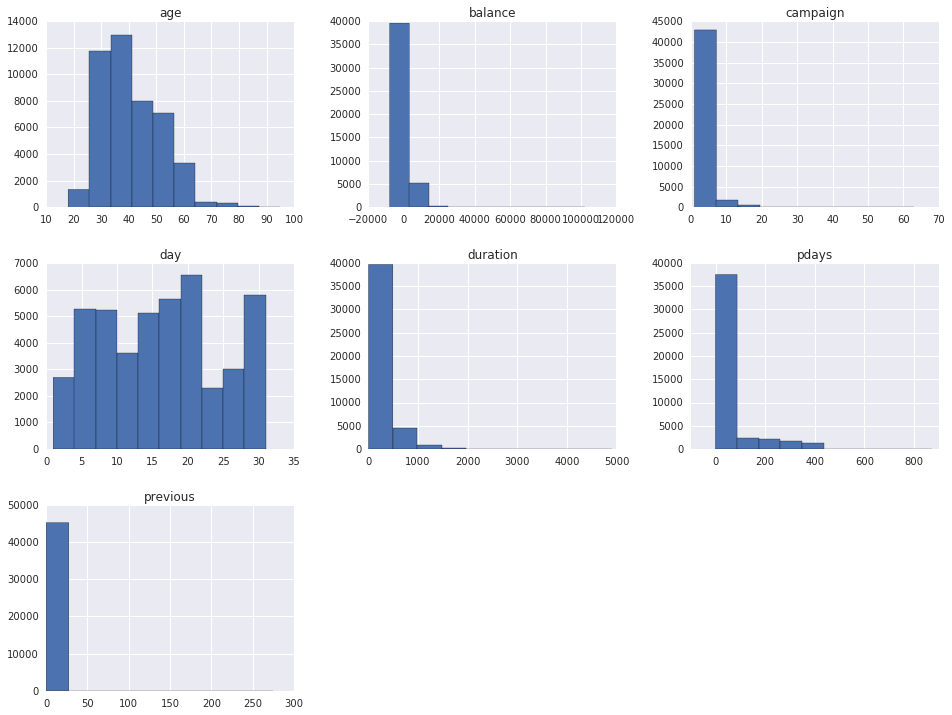

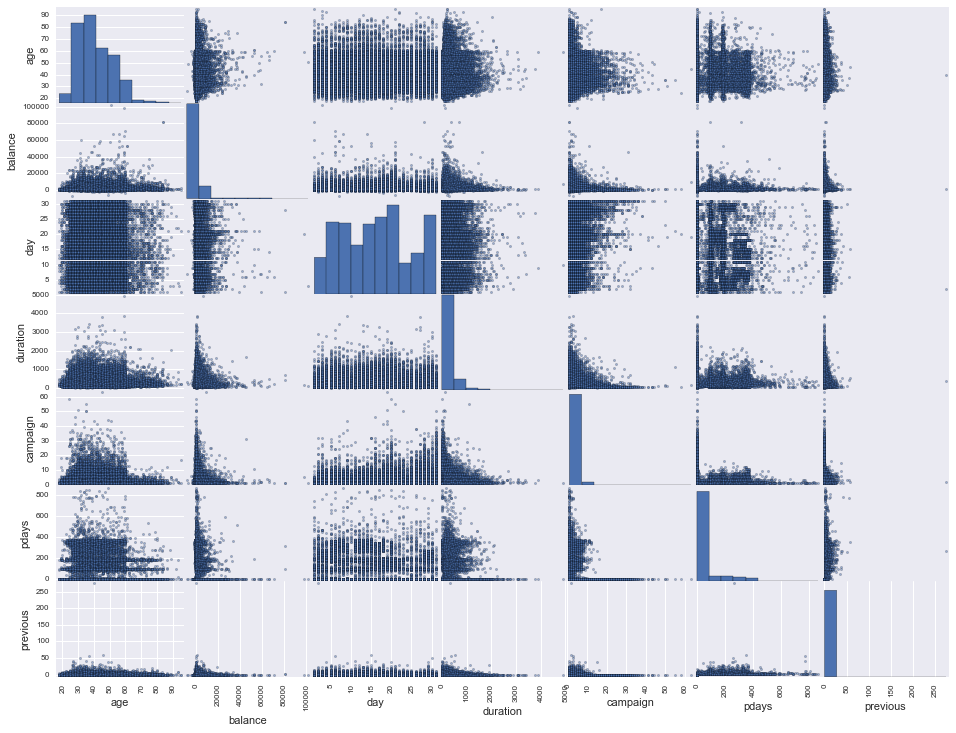

In [128]:
plt.rcParams['figure.figsize'] = 16, 12
campaign_pd[col_cam_num].hist()
plt.show()
pd.tools.plotting.scatter_matrix(campaign_pd[col_cam_num])
plt.show()

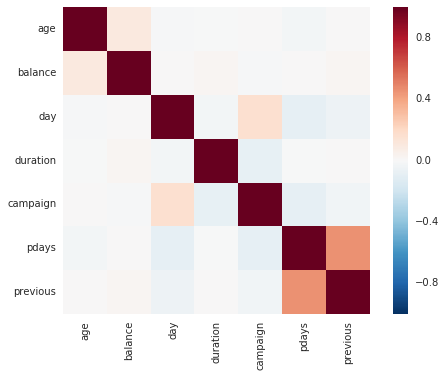

In [124]:
import seaborn as sns
#campaign_pd[col_cam_num].corr()
sns.heatmap(campaign_pd[col_cam_num].corr(), square=True)

In [11]:
campaign_pd['y'] = campaign_pd.apply(lambda x: 1 if x['y'] == 'yes' else 0, axis =1)

job
admin.           0.122027
blue-collar      0.072750
entrepreneur     0.082717
housemaid        0.087903
management       0.137556
retired          0.227915
self-employed    0.118429
services         0.088830
student          0.286780
technician       0.110570
unemployed       0.155027
unknown          0.118056
Name: y, dtype: float64
job
admin.           5171
blue-collar      9732
entrepreneur     1487
housemaid        1240
management       9458
retired          2264
self-employed    1579
services         4154
student           938
technician       7597
unemployed       1303
unknown           288
Name: y, dtype: int64


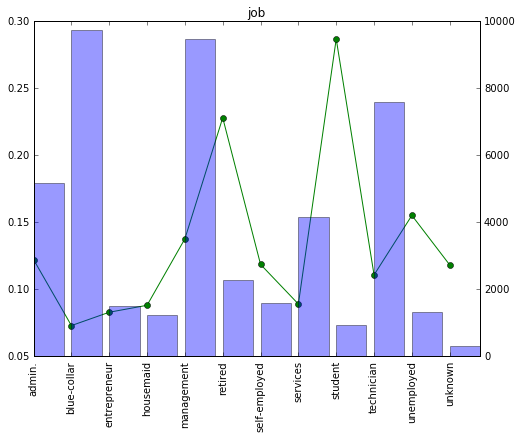

marital
divorced    0.119455
married     0.101235
single      0.149492
Name: y, dtype: float64
marital
divorced     5207
married     27214
single      12790
Name: y, dtype: int64


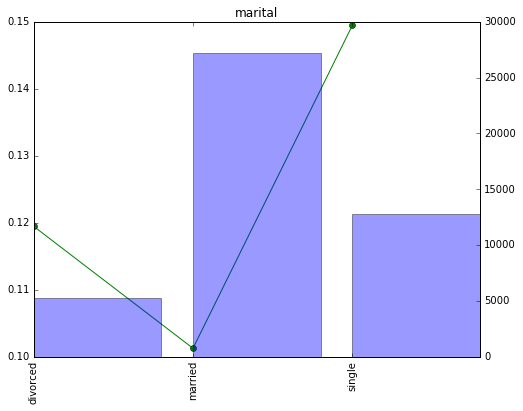

education
primary      0.086265
secondary    0.105594
tertiary     0.150064
unknown      0.135703
Name: y, dtype: float64
education
primary       6851
secondary    23202
tertiary     13301
unknown       1857
Name: y, dtype: int64


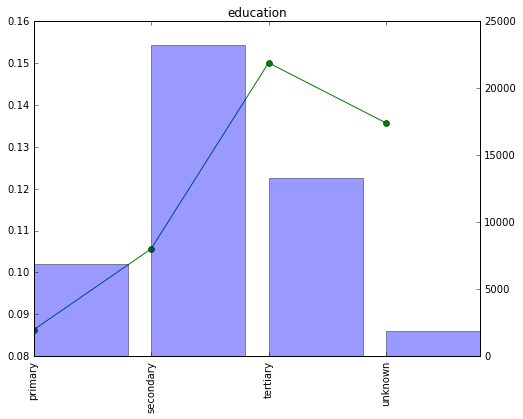

default
no     0.117961
yes    0.063804
Name: y, dtype: float64
default
no     44396
yes      815
Name: y, dtype: int64


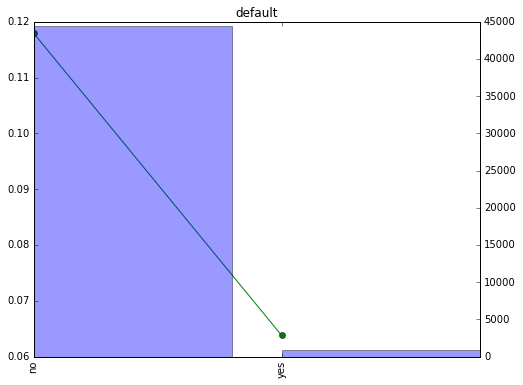

housing
no     0.167024
yes    0.077000
Name: y, dtype: float64
housing
no     20081
yes    25130
Name: y, dtype: int64


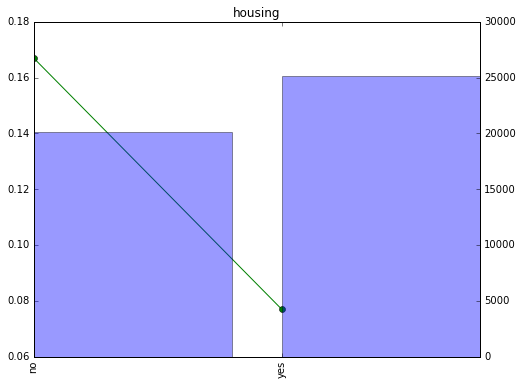

loan
no     0.126557
yes    0.066814
Name: y, dtype: float64
loan
no     37967
yes     7244
Name: y, dtype: int64


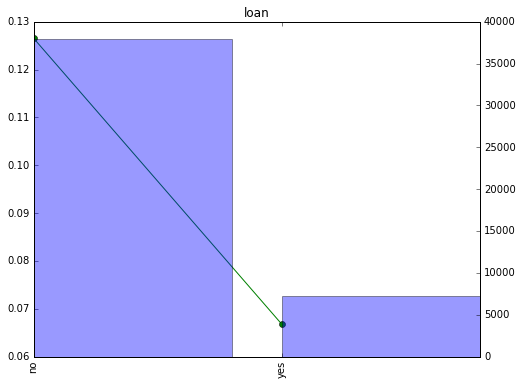

contact
cellular     0.149189
telephone    0.134205
unknown      0.040707
Name: y, dtype: float64
contact
cellular     29285
telephone     2906
unknown      13020
Name: y, dtype: int64


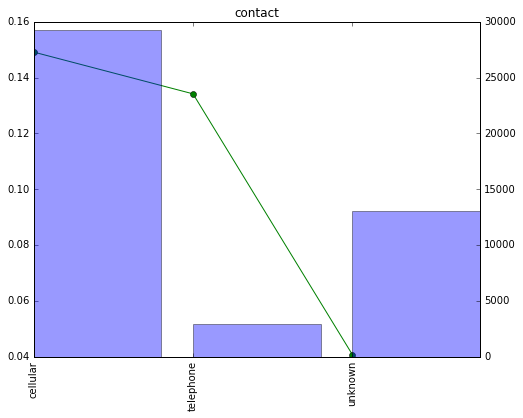

month
apr    0.196794
aug    0.110133
dec    0.467290
feb    0.166478
jan    0.101212
jul    0.090935
jun    0.102228
mar    0.519916
may    0.067195
nov    0.101511
oct    0.437669
sep    0.464594
Name: y, dtype: float64
month
apr     2932
aug     6247
dec      214
feb     2649
jan     1403
jul     6895
jun     5341
mar      477
may    13766
nov     3970
oct      738
sep      579
Name: y, dtype: int64


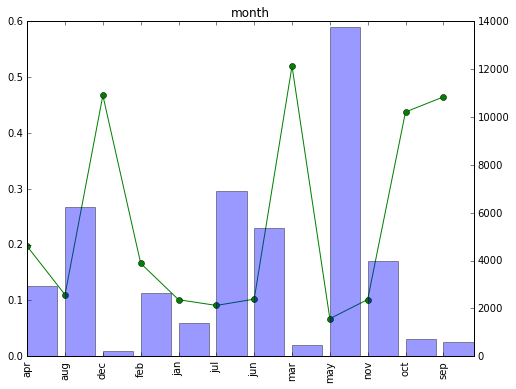

poutcome
failure    0.126097
other      0.166848
success    0.647253
unknown    0.091615
Name: y, dtype: float64
poutcome
failure     4901
other       1840
success     1511
unknown    36959
Name: y, dtype: int64


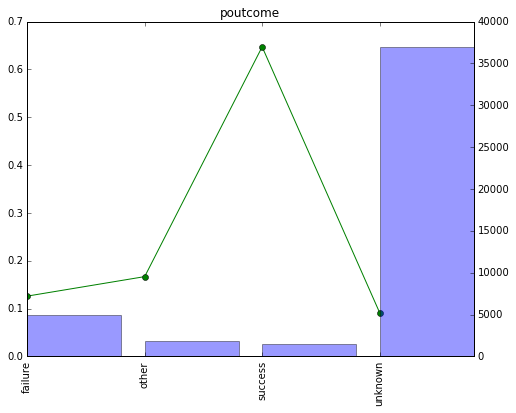

y
0    0
1    1
Name: y, dtype: int64
y
0    39922
1     5289
Name: y, dtype: int64


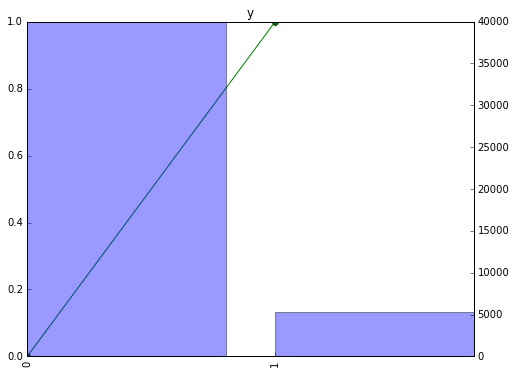

In [12]:
plt.rcParams['figure.figsize'] = 8, 6
def plot_hist_boxplot(var_name, by_var_name, df):
    fig, ax1 = plt.subplots()
    length = len(df[by_var_name].value_counts().index)
    plt.xticks(range(length), df.groupby([by_var_name])[var_name].mean().index, rotation='vertical')
    ax1.plot(range(length), df.groupby([by_var_name])[var_name].mean(), color = 'g', marker = 'o')
    print df.groupby([by_var_name])[var_name].mean()
    print df.groupby([by_var_name])[var_name].count()
    ax2 = ax1.twinx()
    ax2.bar(range(length), df.groupby([by_var_name])[var_name].count(), alpha=0.4)
    plt.title(by_var_name)
    plt.show()
for col in col_cam_str:
    plot_hist_boxplot('y', col, campaign_pd)

## data cleaning
### 1. change three variables to 0 and 1

In [13]:
col_cam_0a1 = ['default', 'housing', 'loan']
for col in col_cam_0a1:
    campaign_pd[col] = campaign_pd[col].apply(lambda x: 1 if x =='yes' else 0)

### 2. bin the month/contact/job variable

month_ind
0    0.100664
1    0.468127
Name: y, dtype: float64
month_ind
0    43203
1     2008
Name: y, dtype: int64


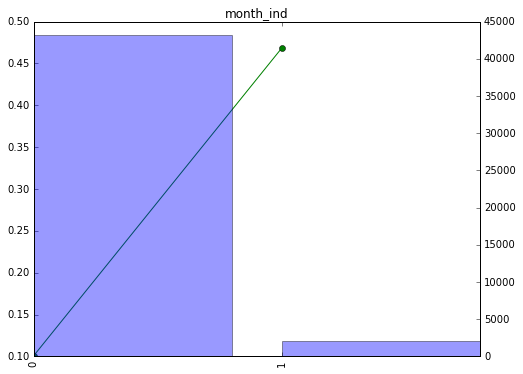

month
apr    577
aug    688
dec    100
feb    441
jan    142
jul    627
jun    546
mar    248
may    925
nov    403
oct    323
sep    269
Name: y, dtype: int64

In [14]:
def month_bin(x):
    if x in ['mar', 'oct', 'sep', 'dec']:
        return 1
    else:
        return 0
    
campaign_pd['month_ind'] = campaign_pd.apply(lambda x: month_bin(x['month']), axis = 1)
plot_hist_boxplot('y', 'month_ind', campaign_pd) 
campaign_pd.loc[campaign_pd['y']==1].groupby(['month'])
campaign_pd.groupby(['month'])['y'].sum()

contact_ind
0    0.040707
1    0.147836
Name: y, dtype: float64
contact_ind
0    13020
1    32191
Name: y, dtype: int64


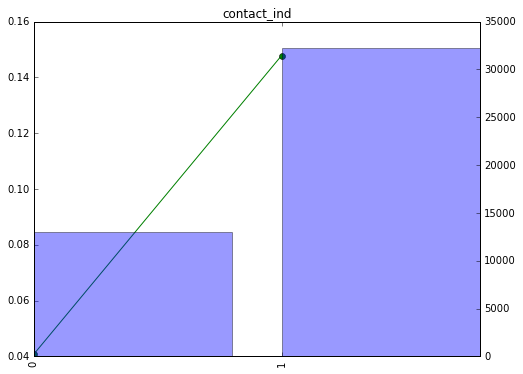

In [15]:
def contact_bin(x):
    if x in ['cellular', 'telephone']:
        return 1
    else:
        return 0
    
campaign_pd['contact_ind'] = campaign_pd.apply(lambda x: contact_bin(x['contact']), axis = 1)
plot_hist_boxplot('y', 'contact_ind', campaign_pd) 

job_ind
0    0.107215
1    0.245159
Name: y, dtype: float64
job_ind
0    42009
1     3202
Name: y, dtype: int64


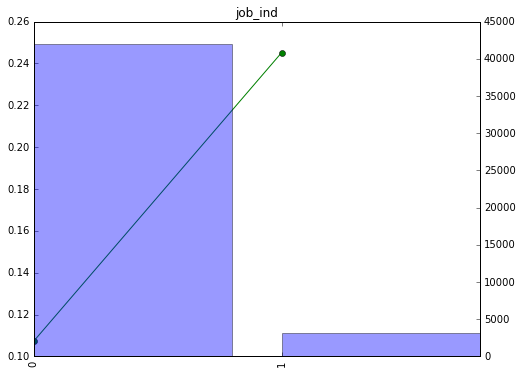

In [16]:
def job_bin(x):
    if x in ['student', 'retired']:
        return 1
    else:
        return 0
campaign_pd['job_ind'] = campaign_pd.apply(lambda x: job_bin(x['job']), axis = 1)
plot_hist_boxplot('y', 'job_ind', campaign_pd)     


### 3. get dummies 

In [17]:
col_cam_dummy = ['marital', 'education', 'poutcome']
campaign_pd_dmy = pd.get_dummies(campaign_pd, columns=col_cam_dummy)

In [18]:
# drop month/contact/job b/c we already binned them
campaign_pd_dmy.drop(['month', 'contact', 'job'], inplace=True, axis = 1)

In [19]:
# campaign_pd_dmy.to_csv('campaign_pd_cleaned.csv', index=False)

In [20]:
print campaign_pd_dmy.head()
print campaign_pd_dmy.shape
print campaign_pd_dmy.info(verbose=True)

   age  default  balance  housing  loan  day  duration  campaign  pdays  \
0   58        0     2143        1     0    5       261         1     -1   
1   44        0       29        1     0    5       151         1     -1   
2   33        0        2        1     1    5        76         1     -1   
3   47        0     1506        1     0    5        92         1     -1   
4   33        0        1        0     0    5       198         1     -1   

   previous        ...         marital_married  marital_single  \
0         0        ...                     1.0             0.0   
1         0        ...                     0.0             1.0   
2         0        ...                     1.0             0.0   
3         0        ...                     1.0             0.0   
4         0        ...                     0.0             1.0   

   education_primary  education_secondary  education_tertiary  \
0                0.0                  0.0                 1.0   
1                0.0  

### 4. create the dataset for baseline model 

In [22]:
campaign_pd_orig = pd.read_csv('project_2/data/bank/bank.csv', sep=';')
campaign_pd_basline = campaign_pd_orig.copy()
campaign_pd_basline['y'] = campaign_pd_orig.apply(lambda x: 1 if x['y'] == 'yes' else 0, axis =1)

In [23]:
col_cam_0a1 = ['default', 'housing', 'loan']
for col in col_cam_0a1:
    campaign_pd_basline[col] = campaign_pd_basline[col].apply(lambda x: 1 if x =='yes' else 0)

In [24]:
col_cam_str = [item for item in campaign_pd_basline.columns if campaign_pd_basline[item].dtype=='O']
print col_cam_str

['job', 'marital', 'education', 'contact', 'month', 'poutcome']


In [25]:
campaign_pd_basline = pd.get_dummies(campaign_pd_basline, columns=col_cam_str)

In [85]:
campaign_pd_basline.to_csv('campaign_pd_basline.csv', index=False)
print campaign_pd_basline.shape
campaign_pd_basline.describe()

(45211, 49)


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,...,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,0.018027,1362.272058,0.555838,0.160226,15.806419,258.163080,2.763841,40.197828,0.580323,...,0.118135,0.010551,0.304483,0.087810,0.016323,0.012807,0.108403,0.040698,0.033421,0.817478
std,10.618762,0.133049,3044.765829,0.496878,0.366820,8.322476,257.527812,3.098021,100.128746,2.303441,...,0.322771,0.102174,0.460193,0.283022,0.126718,0.112441,0.310892,0.197592,0.179735,0.386278
min,18.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,0.000000,72.000000,0.000000,0.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,39.000000,0.000000,448.000000,1.000000,0.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,48.000000,0.000000,1428.000000,1.000000,0.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 4. create baseline model

In [4]:
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


In [50]:
campaign_pd_basline = pd.read_csv('campaign_pd_basline.csv')

In [51]:
X_Train, X_Test, y_Train, y_Test = train_test_split(campaign_pd_basline.drop(['y'], axis =1), 
                                                    campaign_pd_basline['y'], test_size=0.20, random_state=7)
print X_Train.shape, X_Test.shape, y_Train.shape, y_Test.shape

(36168, 48) (9043, 48) (36168L,) (9043L,)


In [52]:
rf_base = RandomForestClassifier(max_depth=6, n_estimators=100)
rf_base.fit(X_Train, y_Train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [53]:
y_pred_rf_Train_p, y_pred_rf_Test_p, y_pred_rf_Train, y_pred_rf_Test = calc_pred_predp(X_Train, X_Test, rf_base)

In [54]:
get_scores(y_Train, y_pred_rf_Train, y_pred_rf_Train_p, 'Baseline RF Train')
get_scores(y_Test, y_pred_rf_Test, y_pred_rf_Test_p, 'Baseline RF Test')    

Baseline RF Train accuracy is 0.896
Baseline RF Train precision is 0.824
Baseline RF Train recall is 0.148
Baseline RF Train f1 is 0.251
Baseline RF Train ROC AUC is 0.92
Baseline RF Test accuracy is 0.899
Baseline RF Test precision is 0.771
Baseline RF Test recall is 0.146
Baseline RF Test f1 is 0.245
Baseline RF Test ROC AUC is 0.91


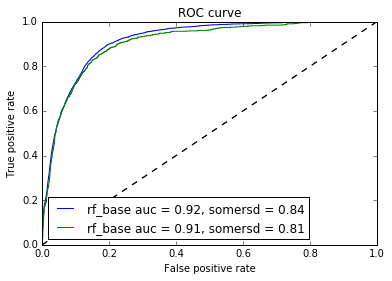

In [106]:
print_roc(y_Train, y_pred_rf_Train, y_pred_rf_Train_p, 'rf_base')
print_roc(y_Test, y_pred_rf_Test, y_pred_rf_Test_p, 'rf_base')
plt.show()


### 5. feature selection

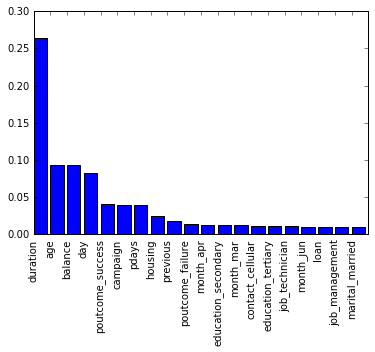

Total importance for top 20 features: 0.825


In [37]:
plot_fet_imp(X_Train, rf_base, 20)

#### add random variables 

In [38]:
campaign_pd_fs = campaign_pd_basline.copy()
np.random.seed(7)
campaign_pd_fs['rand_norm'] = np.random.randn(campaign_pd_fs.shape[0])
campaign_pd_fs['rand_unif'] = np.random.uniform(0, 1, campaign_pd_fs.shape[0])
X_Train, X_Test, y_Train, y_Test = train_test_split(campaign_pd_fs.drop(['y'], axis =1), 
                                                    campaign_pd_fs['y'], test_size=0.20, random_state=7)


In [39]:
rf_fs = RandomForestClassifier(max_depth=6, n_estimators=100)
rf_fs.fit(X_Train, y_Train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

FS RF Train accuracy is 0.897
FS RF Train precision is 0.812
FS RF Train recall is 0.163
FS RF Train f1 is 0.272
FS RF Train ROC AUC is 0.92
FS RF Test accuracy is 0.900
FS RF Test precision is 0.763
FS RF Test recall is 0.164
FS RF Test f1 is 0.270
FS RF Test ROC AUC is 0.91


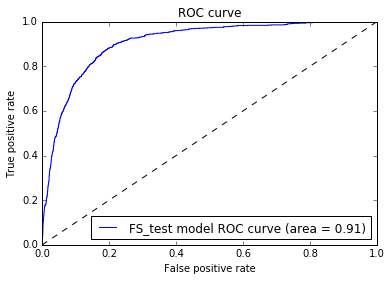

In [40]:
y_pred_fs_Train_p, y_pred_fs_Test_p, y_pred_fs_Train, y_pred_fs_Test = calc_pred_predp(X_Train, X_Test, rf_fs)

get_scores(y_Train, y_pred_fs_Train, y_pred_fs_Train_p, 'FS RF Train')
get_scores(y_Test, y_pred_fs_Test, y_pred_fs_Test_p, 'FS RF Test')  
print_roc(y_Test, y_pred_fs_Test, y_pred_fs_Test_p, 'FS_test')

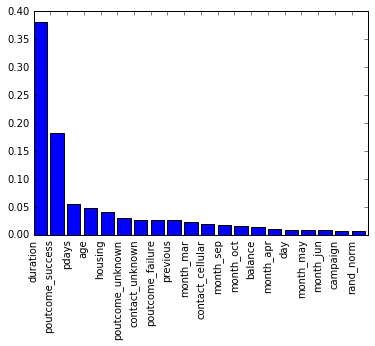

Total importance for top 20 features: 0.949


In [41]:
plot_fet_imp(X_Train, rf_fs, 20)

#### try cleaner dataset with binned variables

In [113]:
campaign_pd_cl = pd.read_csv('campaign_pd_cleaned.csv')

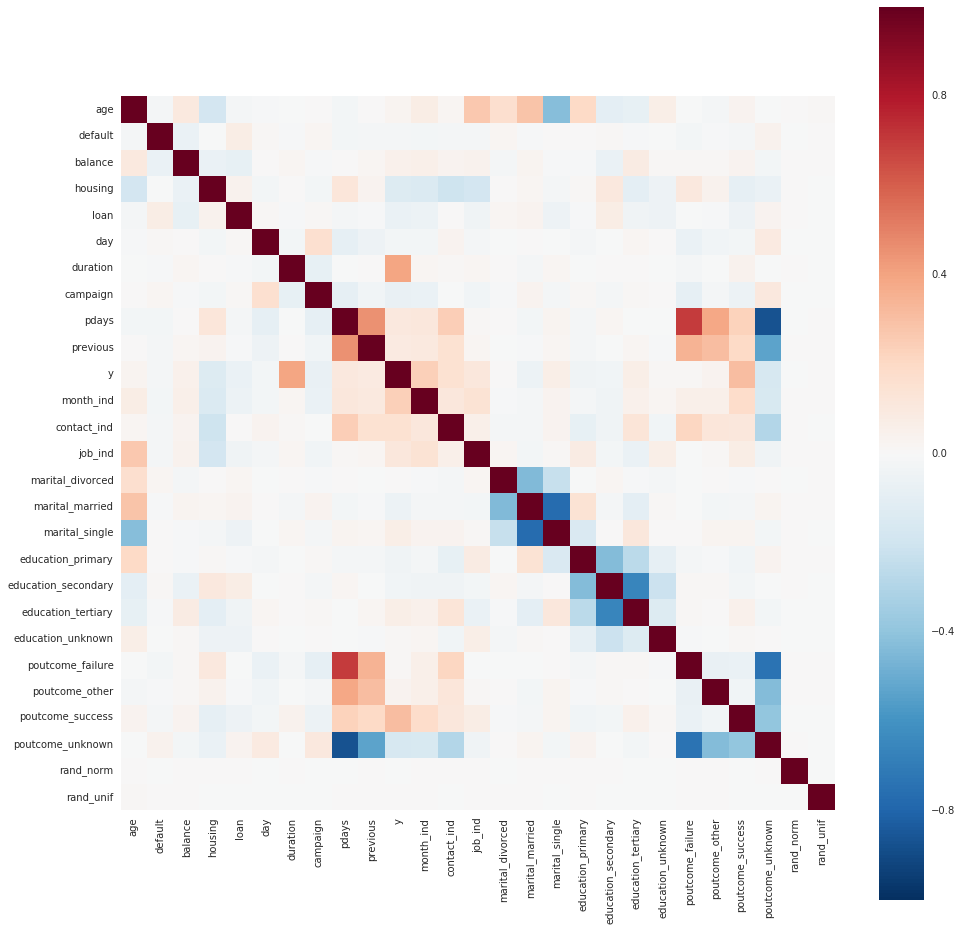

In [127]:
plt.rcParams['figure.figsize'] = 16, 16
sns.heatmap(campaign_pd_cl.corr(), square=True)

In [114]:
np.random.seed(7)
campaign_pd_cl['rand_norm'] = np.random.randn(campaign_pd_cl.shape[0])
campaign_pd_cl['rand_unif'] = np.random.uniform(0, 1, campaign_pd_cl.shape[0])
X_Train, X_Test, y_Train, y_Test = train_test_split(campaign_pd_cl.drop(['y'], axis =1), 
                                                    campaign_pd_cl['y'], test_size=0.20, random_state=7)
print X_Train.shape, X_Test.shape, y_Train.shape, y_Test.shape

(36168, 26) (9043, 26) (36168L,) (9043L,)


In [101]:
rf_cl = RandomForestClassifier(max_depth=6, n_estimators = 200, n_jobs=-1)
rf_cl.fit(X_Train, y_Train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

CL RF Train accuracy is 0.898
CL RF Train precision is 0.794
CL RF Train recall is 0.184
CL RF Train f1 is 0.299
CL RF Train ROC AUC is 0.91
CL RF Test accuracy is 0.900
CL RF Test precision is 0.729
CL RF Test recall is 0.177
CL RF Test f1 is 0.285
CL RF Test ROC AUC is 0.90


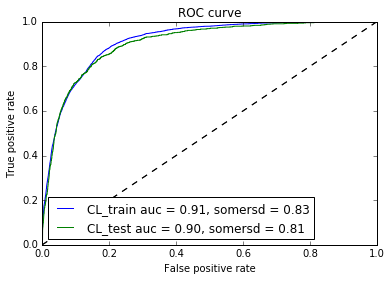

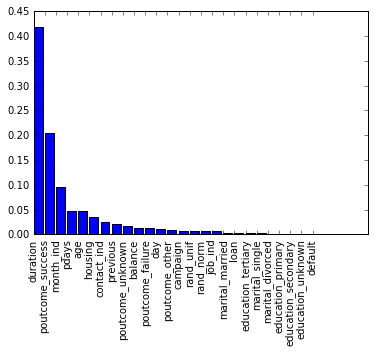

Total importance for top 26 features: 1.000


In [102]:
y_pred_cl_Train_p, y_pred_cl_Test_p, y_pred_cl_Train, y_pred_cl_Test = calc_pred_predp(X_Train, X_Test, rf_cl)
get_scores(y_Train, y_pred_cl_Train, y_pred_cl_Train_p, 'CL RF Train')
get_scores(y_Test, y_pred_cl_Test, y_pred_cl_Test_p, 'CL RF Test')  
print_roc(y_Train, y_pred_cl_Train, y_pred_cl_Train_p, 'CL_train')
print_roc(y_Test, y_pred_cl_Test, y_pred_cl_Test_p, 'CL_test')
plt.show()
plot_fet_imp(X_Train, rf_cl, X_Train.shape[1])

### model on the selected features

In [115]:
fet_nm = X_Train.columns
fet_id = np.argsort(rf_cl.feature_importances_)[::-1]
fet_imp = rf_cl.feature_importances_[fet_id]
fet_nm_sort = fet_nm[fet_id]

In [109]:
sel_fet = []
i = 0
while i < len(fet_nm_sort):
    if 'rand' not in fet_nm_sort[i]:
        sel_fet.append(fet_nm_sort[i])
        i += 1
    else:
        print i, fet_nm_sort[i]
        break
print sel_fet

14 rand_unif
['duration', 'poutcome_success', 'month_ind', 'pdays', 'age', 'housing', 'contact_ind', 'previous', 'poutcome_unknown', 'balance', 'poutcome_failure', 'day', 'poutcome_other', 'campaign']


In [111]:
campaign_pd_rd = pd.read_csv('campaign_pd_cleaned.csv')
campaign_pd_rd = campaign_pd_rd.loc[:, sel_fet + ['y']]
np.random.seed(7)
#campaign_pd_rd['rand_norm'] = np.random.randn(campaign_pd_rd.shape[0])
#campaign_pd_rd['rand_unif'] = np.random.uniform(0, 1, campaign_pd_rd.shape[0])
X_Train, X_Test, y_Train, y_Test = train_test_split(campaign_pd_rd.drop(['y'], axis =1), 
                                                    campaign_pd_rd['y'], test_size=0.20, random_state=7)
print X_Train.shape, X_Test.shape, y_Train.shape, y_Test.shape

(36168, 14) (9043, 14) (36168L,) (9043L,)


In [117]:
rf_rd = RandomForestClassifier(max_depth=6, n_estimators = 200, n_jobs=-1)
rf_rd.fit(X_Train, y_Train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Reduced RF Train accuracy is 0.898
Reduced RF Train precision is 0.796
Reduced RF Train recall is 0.183
Reduced RF Train f1 is 0.298
Reduced RF Train ROC AUC is 0.91
Reduced RF Test accuracy is 0.900
Reduced RF Test precision is 0.728
Reduced RF Test recall is 0.179
Reduced RF Test f1 is 0.288
Reduced RF Test ROC AUC is 0.91


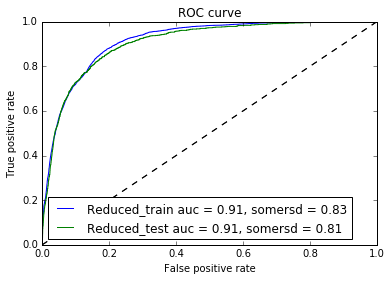

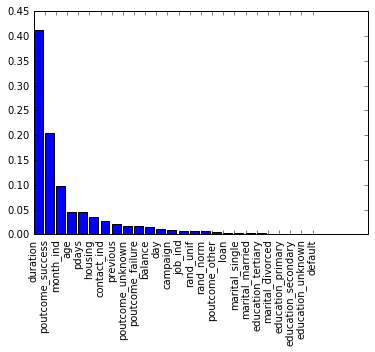

Total importance for top 26 features: 1.000


In [118]:
y_pred_rd_Train_p, y_pred_rd_Test_p, y_pred_rd_Train, y_pred_rd_Test = calc_pred_predp(X_Train, X_Test, rf_rd)
get_scores(y_Train, y_pred_rd_Train, y_pred_rd_Train_p, 'Reduced RF Train')
get_scores(y_Test, y_pred_rd_Test, y_pred_rd_Test_p, 'Reduced RF Test')  
print_roc(y_Train, y_pred_rd_Train, y_pred_rd_Train_p, 'Reduced_train')
print_roc(y_Test, y_pred_rd_Test, y_pred_rd_Test_p, 'Reduced_test')
plt.show()
plot_fet_imp(X_Train, rf_rd, X_Train.shape[1])